In [1]:

%pprint
import sys
if (osp.join('..', 'py') not in sys.path): sys.path.insert(1, osp.join('..', 'py'))

Pretty printing has been turned OFF


In [2]:

from FRVRS import (fu, nu, osp, DataFrame, display, notnull)
import matplotlib.pyplot as plt
import random
%matplotlib inline


# START Triage vs SALT Triage

## Salt and START Triage Differences

* SALT allows for a quick global sorting of the patients so responders can more accurately identify patients who aren’t responding or have an obvious life threat. START relies more on assessing the first person who isn’t Minor (ie triage starts at my feet, not necessarily where the sick patient are).
* Someone who is bleeding can bleed to death in as little as 3-5 minutes. SALT allows for early hemorrhage control. In START Triage, bleeding control doesn’t occur until AFTER respirations are counted and perfusion (cap refill) is checked. This makes SALT faster than START overall AND in hemorrhage control. 
* In SALT, the individual assessment begins with limited rapid lifesaving interventions: 
    * Control major hemorrhage with tourniquets or direct pressure provided by other patients or other devices 
    * Open the airway through positioning or basic airway adjuncts (no advanced airway devices should be used) 
    * If the patient is a child, consider giving 2 rescue breaths 
    * Chest needle decompression 
    * CBRN Antidotes or Autoinjector antidotes 
* START assumes that “All Walking Wounded” are Minor. We know that devastating wounds like upper extremity trauma or penetrating abdominal trauma patients may still be able to ambulate so this is a false assumption. 
* START triage requires responders to count respirations and count and check capillary refill. Literature shows that Assessment must not require counting or timing vital signs and instead use yes–or-no criteria. This makes things easier and faster for responders in high stress environments. 
* SALT includes an Expectant Category for patients who are still breathing but unlikely to survive given curnt resources. 
nt resources. 
resources. 


In [3]:

# Get all CSVs out of one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(829116, 114)



## Walk but not Wave

In [4]:

# Assume issuing "walk" command but not "wave" command indicates lack of SALT training or more instinctive START training
base_mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False)
base_mask_series &= (frvrs_logs_df.is_a_one_triage_file == True)
gb = frvrs_logs_df[base_mask_series].sort_values(['action_tick']).groupby(fu.scene_groupby_columns)
rows_list = []
for (session_uuid, scene_id), scene_df in gb:
    is_walk_command_issued = fu.get_walk_value(scene_df)
    is_wave_command_issued = fu.get_wave_value(scene_df)
    row_dict = {}
    for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
    row_dict['is_walk_command_issued'] = is_walk_command_issued
    row_dict['is_wave_command_issued'] = is_wave_command_issued
    rows_list.append(row_dict)
walk_but_not_wave_df = DataFrame(rows_list)

In [6]:

mask_series = (walk_but_not_wave_df.is_walk_command_issued == 1) & (walk_but_not_wave_df.is_wave_command_issued == 0)
walk_but_not_wave_df[mask_series]

session_uuid  scene_id  is_walk_command_issued  \
7    054918a7-9634-40fe-8356-2ce0c9cc376f         0                       1   
11   09024025-1320-4891-aefa-a497744ed3e2         0                       1   
12   0940a9be-3ff5-4739-b04b-a7605c1ffa2f         0                       1   
13   0950437e-94b0-45bf-8d11-dd446fd0e4a2         0                       1   
18   0bfe46ef-6644-441e-a903-5445f2ee4fd5         0                       1   
..                                    ...       ...                     ...   
351  ea7d43f6-a7ed-4bc7-8002-f056ee415082         0                       1   
364  f2eb6809-d49f-4c3e-be62-91f1538ed437         0                       1   
367  f3447210-99fa-4990-8c1b-747a1e916e79         0                       1   
371  f7b46b02-bc04-42d6-a3aa-abd797948735         0                       1   
375  f8b5cbd1-0abe-483b-8b16-956044dc0119         0                       1   

     is_wave_command_issued  
7                         0  
11                        0  
12                        0  
13                        0  
18                        0  
..                      ...  
351                       0  
364                       0  
367                       0  
371                       0  
375                       0  

[64 rows x 4 columns]


## Triage Timeline

In [5]:

rows_list = []
for (session_uuid, scene_id), scene_df in fu.get_session_groupby(frvrs_logs_df, mask_series=None, extra_column='scene_id'):
    for patient_id, patient_df in scene_df.groupby('patient_id'):
        mask_series = ~patient_df.tool_applied_type.isnull() | ~patient_df.tag_applied_type.isnull()
        df = patient_df[mask_series]
        if df.shape[0]:
            # display(df.dropna(axis='columns', how='all').T); raise
            for row_index, row_series in df.iterrows():
                row_dict = {}
                for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
                row_dict['action_tick'] = row_series.action_tick
                action_type = row_series.action_type
                if (action_type == 'TOOL_APPLIED'): row_dict['timeline_notes'] = f'Tool applied: {row_series.tool_applied_type}'
                elif (action_type == 'TAG_APPLIED'): row_dict['timeline_notes'] = f'Tag applied: {row_series.tag_applied_type}'
                rows_list.append(row_dict)
triage_timeline_df = DataFrame(rows_list)

In [6]:

triage_timeline_df

session_uuid  scene_id   patient_id  \
0     04882754-51a0-4e5b-9617-b200e3609116           1  Mike_0 Root   
1     04882754-51a0-4e5b-9617-b200e3609116           1  Mike_0 Root   
2     04882754-51a0-4e5b-9617-b200e3609116           1  Mike_1 Root   
3     04882754-51a0-4e5b-9617-b200e3609116           1  Mike_1 Root   
4     04882754-51a0-4e5b-9617-b200e3609116           1  Mike_2 Root   
...                                    ...         ...          ...   
3379  ff97fc56-c803-4aa7-b419-35e0ac17d0b3           2  Mike_5 Root   
3380  ff97fc56-c803-4aa7-b419-35e0ac17d0b3           2  Mike_5 Root   
3381  ff97fc56-c803-4aa7-b419-35e0ac17d0b3           2  Mike_5 Root   
3382  ff97fc56-c803-4aa7-b419-35e0ac17d0b3           2  Mike_7 Root   
3383  ff97fc56-c803-4aa7-b419-35e0ac17d0b3           2  Mike_7 Root   

      action_tick                timeline_notes  
0           160026  Tool applied: Gauze_Dressing  
1           167410            Tag applied: green  
2            81427      Tool applied: Tourniquet  
3            86304           Tag applied: yellow  
4           122877      Tool applied: Gauze_Pack  
...            ...                           ...  
3379        390066      Tool applied: Tourniquet  
3380        399830      Tool applied: Gauze_Pack  
3381        408517              Tag applied: red  
3382        367218      Tool applied: Tourniquet  
3383        378576           Tag applied: yellow  

[3384 rows x 5 columns]

In [7]:

# Get the scene with the most patients

groupby = triage_timeline_df.groupby(fu.scene_groupby_columns)
session_uuid, scene_id = list(groupby.patient_id.nunique('patient_id').sort_values().tail(1).index.values)[0]

In [8]:

from matplotlib.text import Text
import humanize
from datetime import timedelta

def display_timelines(random_session_uuid=None, random_time_group=None, verbose=False):
    
    # Get a random session
    if random_session_uuid is None:
        random_session_uuid = random.choice(frvrs_logs_df.session_uuid.unique())
    
    # Get a random scene from within the session
    if random_time_group is None:
        mask_series = (frvrs_logs_df.session_uuid == random_session_uuid)
        random_time_group = random.choice(frvrs_logs_df[mask_series].scene_id.unique())
    
    # Get the event time and elapsed time of each person engaged
    base_mask_series = (frvrs_logs_df.session_uuid == random_session_uuid) & (frvrs_logs_df.scene_id == random_time_group)
    mask_series = base_mask_series & (~frvrs_logs_df.tool_applied_type.isnull() | ~frvrs_logs_df.tag_applied_type.isnull())
    columns_list = ['patient_id', 'action_type', 'action_tick', 'tool_applied_type', 'tag_applied_type']
    patient_engagements_df = frvrs_logs_df[mask_series][columns_list].sort_values(['action_tick'])
    if verbose: display(patient_engagements_df)
    
    # For each patient, get a timeline of every reference on or before engagement
    color_cycler = nu.get_color_cycler(len(patient_engagements_df.patient_id.unique()))
    hlineys_list = []; hlinexmins_list = []; hlinexmaxs_list = []; hlinecolors_list = []; hlinelabels_list = []
    hlineaction_types_list = []; vlinexs_list = []
    left_lim = 999999; right_lim = -999999
    for (patient_id, df), (y, face_color_dict) in zip(patient_engagements_df.groupby('patient_id'), enumerate(color_cycler())):
        y = 0
    
        # Get the broad horizontal line parameters
        hlineys_list.append(y)
        face_color = face_color_dict['color']
        hlinecolors_list.append(face_color)
        hlinelabels_list.append(patient_id)
        
        if verbose: display(df); raise
    
        # Get the fine horizontal line parameters and plot dimensions
        xmin = df.action_tick.min(); hlinexmins_list.append(xmin);
        if xmin < left_lim: left_lim = xmin
        xmax = df.action_tick.max(); hlinexmaxs_list.append(xmax);
        if xmax > right_lim: right_lim = xmax
        
        # Get the action type annotation parameters
        for row_index, row_series in df.iterrows():
            x = row_series.action_tick
            action_type = row_series.action_type
            if (action_type == 'TOOL_APPLIED'): label = row_series.tool_applied_type.replace('Gauze_', '')
            elif (action_type == 'TAG_APPLIED'): label = row_series.tag_applied_type
            annotation_tuple = (label, x, y)
            hlineaction_types_list.append(annotation_tuple)
    
    ax = plt.figure(figsize=(18, 9/4)).add_subplot(1, 1, 1)
    
    # Add the timelines to the figure subplot axis
    line_collection_obj = ax.hlines(hlineys_list, hlinexmins_list, hlinexmaxs_list, colors=hlinecolors_list)
    
    # Label each timeline with the appropriate patient name
    for label, x, y in zip(hlinelabels_list, hlinexmins_list, hlineys_list):
        plt.annotate(label.replace(' Root', ''), (x, y), textcoords='offset points', xytext=(-4, 25), ha='left')
    
    # Annotate the action types along their timeline
    for annotation_tuple in hlineaction_types_list:
        label, x, y = annotation_tuple
        plt.annotate(label, (x, y), textcoords='offset points', xytext=(0, 0), ha='center', va='center', rotation=90, fontsize=6)
    
    # Remove the ticks and tick labels from the y axis
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    ax.set_xticklabels([
        Text(200000.0, 0, humanize.precisedelta(timedelta(milliseconds=200000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(250000.0, 0, humanize.precisedelta(timedelta(milliseconds=250000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(300000.0, 0, humanize.precisedelta(timedelta(milliseconds=300000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(350000.0, 0, humanize.precisedelta(timedelta(milliseconds=350000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(400000.0, 0, humanize.precisedelta(timedelta(milliseconds=400000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(450000.0, 0, humanize.precisedelta(timedelta(milliseconds=450000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(500000.0, 0, humanize.precisedelta(timedelta(milliseconds=500000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(550000.0, 0, humanize.precisedelta(timedelta(milliseconds=550000.0)).replace(', ', ',\n').replace(' and ', ' and\n'))
    ]);
    
    # Move the top and right border out so that the annotations don't cross it
    plt.subplots_adjust(top=1.5)
    xlim_tuple = ax.set_xlim(left_lim-10_000, right_lim+20_000)
    
    # Set the title and labels
    ax.set_title(f'Multi-Patient Timeline for UUID {random_session_uuid} and Scene {random_time_group}')
    ax.set_xlabel('Elapsed Time since Scene Start')

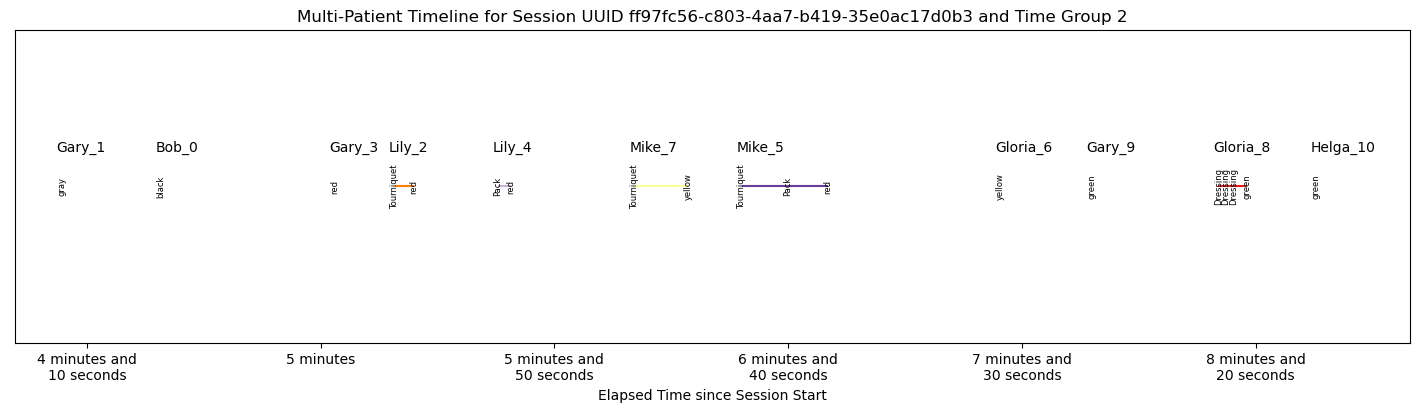

In [9]:

display_timelines(random_session_uuid=session_uuid, random_time_group=scene_id, verbose=False)

In [10]:

frvrs_logs_df.patient_demoted_sort.unique()

array([nan, 'waver', 'walker', 'still'], dtype=object)

In [11]:

# Get a list of walkers and their injuries
injury_record_ids_set = set()


for (session_uuid, scene_id, patient_id), patient_df in frvrs_logs_df.groupby(fu.patient_groupby_columns):
    mask_series = (patient_df.patient_demoted_sort == 'walker')
    if mask_series.any():
        mask_series = patient_df.injury_record_id.isnull()
        if patient_df[~mask_series].shape[0]:
            injury_record_ids_list = patient_df[~mask_series].injury_record_id.tolist()
            if injury_record_ids_list:
                mask_series = (patient_df.action_type == 'PATIENT_RECORD')
                if mask_series.any(): print(session_uuid, scene_id, patient_id, injury_record_ids_list)
                for injury_record_id in injury_record_ids_list:
                    injury_record_ids_set.add(injury_record_id)
print(f'So, maybe the key is to access their treatment of walkers and see if they attend to the extremely traumatized first.', end=' ')
print(f'But the only injury record IDs I have are {nu.conjunctify_nouns(injury_record_ids_set)}.')

06574b6f-ab02-432c-9a65-7b031218a270 3 Mike_2 Root ['L Shoulder Puncture']
0b891add-e0c3-463d-948d-7f491f1d10ef 2 Mike_2 Root ['L Shoulder Puncture']
0b891add-e0c3-463d-948d-7f491f1d10ef 4 Bob_12 Root ['Asthmatic']
0b891add-e0c3-463d-948d-7f491f1d10ef 4 Lily_11 Root ['L Forearm Laceration', 'L Bicep Puncture']
9d142377-69d6-4622-958d-a29a6a0a0d21 1 Mike_2 Root ['L Shoulder Puncture']
a0987257-801e-44c5-a1ad-81e0083bfa46 1 Mike_2 Root ['L Shoulder Puncture']
a0987257-801e-44c5-a1ad-81e0083bfa46 3 Gary_5 Root ['Asthmatic']
So, maybe the key is to access their treatment of walkers and see if they attend to the extremely traumatized first. But the only injury record IDs I have are L Shoulder Puncture, L Forearm Laceration, L Bicep Puncture, and Asthmatic.


In [12]:

frvrs_logs_df.injury_record_id.unique()

array([nan, 'R Forearm Laceration', 'L Thigh Laceration',
       'L Shoulder Puncture', 'R Chest Collapse', 'Face Shrapnel',
       'L Wrist Amputation', 'L Chest Collapse', 'L Stomach Puncture',
       'R Shin Amputation', 'L Side Puncture', 'R Side Puncture',
       'R Thigh Laceration', 'R Calf Shrapnel', 'L Thigh Puncture',
       'R Calf Laceration', 'L Forearm Laceration', 'Ear Bleed',
       'Forehead Scrape', 'L Bicep Puncture', 'Asthmatic',
       'R Shoulder Puncture', 'L Shin Amputation', 'L Calf Shrapnel',
       'R Bicep Puncture', 'R Wrist Amputation', 'R Palm Laceration',
       'L Calf Laceration'], dtype=object)

In [13]:

def investigate_object(search_str, columns_list=None, verbose=False):
    '''
    Investigate the presence of search_str and
    make a list of all search_str references
    '''
    if columns_list is None:
        srs = frvrs_logs_df.applymap(lambda x: search_str.lower() in str(x).lower(), na_action='ignore').sum()
        mask_series = (srs > 0)
        columns_list = srs[mask_series].index.tolist()
    if verbose: print(columns_list)
    sample_mask_series = False
    references_list = []
    for cn in columns_list:
        mask_series = frvrs_logs_df[cn].map(lambda x: search_str in str(x))
        sample_mask_series |= mask_series
        references_list.extend(frvrs_logs_df[mask_series][cn].unique().tolist())
    if verbose: print(nu.conjunctify_nouns(set(references_list)))
    df = frvrs_logs_df[sample_mask_series].dropna(axis='columns', how='all')
    display(df.sample(min(4, df.shape[0])).T.dropna(axis='index', how='all'))

In [14]:

search_str = 'tourniquet'
investigate_object(search_str, columns_list=None)

34740   \
action_type                                                               INJURY_TREATED   
action_tick                                                                      126774   
event_time                                                           2023-03-07 12:55:00   
session_uuid                                        f90a6408-2a18-49b4-8a6b-edee48e7e9ed   
file_name                                                                        Marty18   
scene_id                                                                             1   
injury_record_id                                                                     NaN   
injury_record_patient_id                                                             NaN   
injury_record_required_procedure                                                     NaN   
injury_record_severity                                                               NaN   
injury_record_body_region                                                            NaN   
injury_record_injury_treated                                                         NaN   
injury_record_injury_treated_with_wrong_treatment                                    NaN   
injury_record_injury_injury_locator                                                  NaN   
injury_treated_id                                                     L Thigh Laceration   
injury_treated_patient_id                                                    Mike_1 Root   
injury_treated_required_procedure                                             tourniquet   
injury_treated_severity                                                           medium   
injury_treated_body_region                                                       leftLeg   
injury_treated_injury_treated                                                       True   
injury_treated_injury_treated_with_wrong_treatment                                 False   
injury_treated_injury_injury_locator                                     (2.8, 0.3, 0.4)   
tool_applied_type                                                                    NaN   
tool_applied_attachment_point                                                        NaN   
tool_applied_tool_location                                                           NaN   
tool_applied_data                                                                    NaN   
tool_applied_sender                                                                  NaN   
tool_applied_patient_id                                                              NaN   
patient_id                                                                   Mike_1 Root   
location_id                                                              (2.8, 0.3, 0.4)   
delta_to_next_action                                                                 NaT   

                                                                                        136735  \
action_type                                                                       TOOL_APPLIED   
action_tick                                                                            355799   
event_time                                                                 2023-04-21 10:50:00   
session_uuid                                              313259a4-162f-44f6-8479-92e4554a1464   
file_name                                                                                max14   
scene_id                                                                                   2   
injury_record_id                                                                           NaN   
injury_record_patient_id                                                                   NaN   
injury_record_required_procedure                                                           NaN   
injury_record_severity                                                                     NaN   
injury_record_body_region                                        

In [15]:

frvrs_logs_df.injury_treated_id.unique()

array([nan, 'R Chest Collapse', 'L Thigh Laceration',
       'L Shoulder Puncture', 'R Forearm Laceration', 'L Thigh Puncture',
       'R Calf Laceration', 'R Thigh Laceration', 'R Side Puncture',
       'R Shin Amputation', 'L Side Puncture', 'L Forearm Laceration',
       'R Calf Shrapnel', 'R Shoulder Puncture', 'L Shin Amputation',
       'Face Shrapnel', 'R Wrist Amputation', 'L Stomach Puncture'],
      dtype=object)

In [16]:

# Get a list of walkers that require a tourniquet
injury_record_ids_set = set()


for (session_uuid, scene_id, patient_id), patient_df in frvrs_logs_df.groupby(fu.patient_groupby_columns):
    mask_series = (patient_df.patient_demoted_sort == 'walker')
    if mask_series.any():
        mask_series = patient_df.injury_record_id.isnull()
        if patient_df[~mask_series].shape[0]:
            injury_record_ids_list = patient_df[~mask_series].injury_record_id.tolist()
            if injury_record_ids_list:
                mask_series = (patient_df.injury_treated_required_procedure == 'tourniquet')
                if mask_series.any(): print(session_uuid, scene_id, patient_id, injury_record_ids_list)
                for injury_record_id in injury_record_ids_list:
                    injury_record_ids_set.add(injury_record_id)

In [17]:

search_str = 'Expectant'
investigate_object(search_str, columns_list=None, verbose=True)

['patient_demoted_salt', 'patient_record_salt', 'voice_capture_message', 'patient_engaged_salt']



Empty DataFrame
Columns: []
Index: []

In [18]:

frvrs_logs_df.patient_demoted_salt.unique()

array([nan, 'DELAYED', 'IMMEDIATE', 'EXPECTANT', 'DEAD', 'MINIMAL'],
      dtype=object)

In [19]:

frvrs_logs_df.patient_record_salt.unique()

array([nan, 'MINIMAL', 'DELAYED', 'IMMEDIATE', 'DEAD', 'EXPECTANT'],
      dtype=object)

In [20]:

frvrs_logs_df.patient_engaged_salt.unique()

array([nan, 'IMMEDIATE', 'DELAYED', 'MINIMAL', 'EXPECTANT', 'DEAD'],
      dtype=object)

In [24]:

# Find out if any of the expectants are not lying still
actions_list = ['demoted', 'record', 'engaged']
mask_series = False
for action in actions_list:
    mask_series |= (frvrs_logs_df[f'patient_{action}_salt'] == 'EXPECTANT')
sorts_set = set()
for action in actions_list:
    for sort in frvrs_logs_df[mask_series][f'patient_{action}_sort'].unique():
        if notnull(sort):
            sorts_set.add(sort)
sorts_list = nu.conjunctify_nouns([f'"{sort}"' for sort in sorts_set], and_or='or')
print(f'The expectant patients are all {sorts_list}.')
display(frvrs_logs_df[mask_series].sample(7).T.dropna(axis='index', how='all'))

The expectant patients are all "still".


80595  \
action_type                                                 PATIENT_ENGAGED   
action_tick                                                         348664   
event_time                                              2023-05-11 10:37:00   
session_uuid                           8581c1f8-a4e8-4245-ac73-2bd671237001   
file_name                              8581c1f8-a4e8-4245-ac73-2bd671237001   
scene_id                                                                2   
patient_demoted_health_level                                            NaN   
patient_demoted_health_time_remaining                                   NaN   
patient_demoted_patient_id                                                      NaN   
patient_demoted_position                                                NaN   
patient_demoted_rotation                                                NaN   
patient_demoted_salt                                                    NaN   
patient_demoted_sort                                                    NaN   
patient_demoted_pulse                                                   NaN   
patient_demoted_breath                                                  NaN   
patient_demoted_hearing                                                 NaN   
patient_demoted_mood                                                    NaN   
patient_demoted_pose                                                    NaN   
patient_record_health_level                                             NaN   
patient_record_health_time_remaining                                    NaN   
patient_record_patient_id                                                       NaN   
patient_record_position                                                 NaN   
patient_record_rotation                                                 NaN   
patient_record_salt                                                     NaN   
patient_record_sort                                                     NaN   
patient_record_pulse                                                    NaN   
patient_record_breath                                                   NaN   
patient_record_hearing                                                  NaN   
patient_record_mood                                                     NaN   
patient_record_pose                                                     NaN   
patient_engaged_health_level                                            100   
patient_engaged_health_time_remaining                              Infinity   
patient_engaged_patient_id                                              Gary_1 Root   
patient_engaged_position                                    (1.6, 0.0, 7.6)   
patient_engaged_rotation                               (0.0, 1.0, 0.0, 0.0)   
patient_engaged_salt                                              EXPECTANT   
patient_engaged_sort                                                  still   
patient_engaged_pulse                                                  none   
patient_engaged_breath                                           restricted   
patient_engaged_hearing                                                none   
patient_engaged_mood                                           unresponsive   
patient_engaged_pose                                                 supine   
patient_id                                                      Gary_1 Root   
location_id                                                 (1.6, 0.0, 7.6)   

                                                                      24817  \
action_type                                                  PATIENT_RECORD   
action_tick                                                          64321   
event_time                                              2023-05-16 13:59:00   
session_uuid                           e78faf41-7bbd-410b-8750-e4e72b951216   
file_name                              e78faf41-7bbd-410b-8750-e4e72b951216   
scene_id            

In [149]:

str(list(sorts_set)[0])

'nan'